# Inorganic Carbon Equilibria
This notebook generates Fig. SY, which plots hydrated Ci species as a function of pH and atmospheric CO2 percentage. $CO_2$ and $H_{total}$ equilibrium calculations. 

Based on a notebook associated with Mangan, Flamholz* et al. PNAS 2016. Thanks to Elad Noor for the initial implementation. 

In [1]:
mkdir -p ../figures/figS16

In [2]:
import numpy as np
import pylab
import seaborn as sns 

from matplotlib import pyplot as plt
from numpy import log, exp, linspace, matrix
from scipy.special import logsumexp

plt.style.use("seaborn-v0_8-muted")
state_color = "navy"
arrow_color = "black"

In [3]:
dG0_H2O = -237.2 # kJ/mol
R = 8.31e-3 # kJ/(K*mol)
T = 298.15 # K

# Standard formation energies for every specie. Data from Alberty (2003). 
Alberty = {'CO2(g)':    {'nH':0, 'z':0,  'dG0_f': -394.36},
           'CO2(sp)':   {'nH':0, 'z':0,  'dG0_f': -385.97},
           'CO2(aq)':   {'nH':2, 'z':0,  'dG0_f': -385.97 - 237.13},
           'H2O(l)':    {'nH':2, 'z':0,  'dG0_f': -237.13},
           'H2CO3(sp)': {'nH':2, 'z':0,  'dG0_f': -606.33},
           'HCO3-(sp)': {'nH':1, 'z':-1, 'dG0_f': -586.77},
           'CO3-2(sp)': {'nH':0, 'z':-2, 'dG0_f': -527.81}}

# Pretty LaTeX style names for captions. 
PrettyNames = {'CO2(g)': r'$CO_2 Gas$',
               'CO2(sp)': r'$Aqueous CO_2$',
               'CO2(aq)': r'$Aqueous CO_2 + H_2O$',
               'H2O(l)': r'$H_20$',
               'H2CO3(sp)': r'$H_2CO_3$',
               'HCO3-(sp)': r'$HCO_3^-$',
               'CO3-2(sp)': r'$CO_3^{2-}$'}

# Mapping of KEGG IDs to protonation states of particular chemical species.
# Protonations states (AKA pseudoisomers) assumed to be in equilibrium with pH.
KEGG2sp = {'C00288': ['H2CO3(sp)', 'HCO3-(sp)', 'CO3-2(sp)'], # H_total
           'C00001': ['H2O(l)'],
           'C00011': ['CO2(sp)'],
           'C99998': ['CO2(aq)']} # False KEGG ID for CO2 + H2O

In [4]:
# Debye-Huckel
# Approximation of the temperature dependency of ionic strength effects
DH_alpha = 1e-3*(9.20483*T) - 1e-5*(1.284668 * T**2) + 1e-8*(4.95199 * T**3)
DH_beta = 1.6
def debye_huckel(I):
    """Approximation of the temperature dependency of ionic strength effects."""
    return DH_alpha * I**(0.5) / (1.0 + DH_beta * I**(0.5))

def transform(species, pH, I):
    """Calculates the dG' for the species group.
    
    Calculates a single formation energy for the entire group,
    transforming to account for the effect of pH and ionic strength
    at the absolute temperature specified above.
    
    Args:
        species: the identified for the group of species.
        pH: the pH.
        I: the ionic strength, molar units.
    """ 
    DH = debye_huckel(I)
    dG0_primes = []
    for d in map(Alberty.get, species):
        dG0_prime = d['dG0_f'] + \
                    d['nH'] * (R*T*log(10)*pH + DH) - \
                    d['z']**2 * DH
        dG0_primes.append(dG0_prime)
    dG0_prime_tot = -R*T * logsumexp([-x/(R*T) for x in dG0_primes])
    
    P = map(lambda x: exp((dG0_prime_tot - x)/(R*T)), dG0_primes)
    return dG0_prime_tot, dict(zip(species, P))

def calc_dG0_prime(sparse, pH, I):
    dG0_prime = 0
    for kegg_id, coeff in sparse.items():
        dG0_prime += coeff * transform(KEGG2sp[kegg_id], pH, I)[0]
    return dG0_prime


def Hcp_CO2(T):
    """Calculate CO2 Henry's law coefficient based on Sander, Atmos Chem Phys 2015. 
    
    Args:
        T: temperature at which to calculate Hcp.
        
    Returns:
        Hcp at the given temperature [mol / (m^3*Pa)]
    """
    Hcp_ref = 3.3e-4 # mol / (m^3*Pa)
    Tfactor = 2400 # d ln(Hcp) / d (1/T)
    Tref = 298.15
    Tdiff_term = (1/T)-(1/Tref)
    return Hcp_ref * np.exp(Tfactor*Tdiff_term)


def CO2_aq(pCO2, T):
    """Calculate the Henry's law equilibrium aqueous CO2 concentration.
    
    Args:
        pCO2: The gas phase partial pressure of CO2 as a fraction (not percent).
        T: the temperature at which to calculate the equilibrium. 
        
    Returns:
        Molar CO2 concentration at equilibrium in the aqueous phase.
    """
    Hcp = Hcp_CO2(T) # mol / (m^3*Pa)
    patm_pascals = 101325
    pCO2_pascals = pCO2*patm_pascals
    # factor of 1e-3 converts to molar (mol/L) from mol/m^3
    return pCO2_pascals*Hcp*1e-3


In [5]:
# Calculate the pKas from dGf without DH correction for ionic strength.
h2co3_d   = Alberty['H2CO3(sp)']
hco3_d    = Alberty['HCO3-(sp)']
co3_d     = Alberty['CO3-2(sp)']
co2aq_d   = Alberty['CO2(aq)']
dGf_h2co3 = h2co3_d['dG0_f']
dGf_hco3  = hco3_d['dG0_f']
dGf_co3   = co3_d['dG0_f']
dGf_co2aq = co2aq_d['dG0_f']

pKa1 = (dGf_hco3 - dGf_h2co3) / (R*T*log(10))
pKa2 = (dGf_co3 - dGf_hco3) / (R*T*log(10))
pKa_eff = (dGf_hco3 - dGf_co2aq) / (R*T*log(10))
print('H2CO3 pKas (I = 0)')
print('pKa1 = %.2f' % pKa1)
print('pKa2 = %.2f' % pKa2)
print('pKa_eff = %.2f' % pKa_eff)
print()

# Calculate the pKas from dGf WITH DH correction for ionic strength.
ionic_s = .2 # in [M]
DH = debye_huckel(ionic_s)
dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
print('H2CO3 pKas (I = %.2f [M])' % ionic_s)
print('pKa1 = %.2f' % pKa1)
print('pKa2 = %.2f' % pKa2)
print('pKa_eff = %.2f' % pKa_eff)
print()

ionic_s = .05 # in [M]
DH = debye_huckel(ionic_s)
dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
print('H2CO3 pKas (I = %.2f [M])' % ionic_s)
print('pKa1 = %.2f' % pKa1)
print('pKa2 = %.2f' % pKa2)
print('pKa_eff = %.2f' % pKa_eff)
print()

# assert that the acid and base have equal dG'0 in the calculated pKa:
np.testing.assert_almost_equal(transform(['HCO3-(sp)'], pKa1, ionic_s)[0],
                               transform(['H2CO3(sp)'], pKa1, ionic_s)[0])
np.testing.assert_almost_equal(transform(['CO3-2(sp)'], pKa2, ionic_s)[0],
                               transform(['HCO3-(sp)'], pKa2, ionic_s)[0])
np.testing.assert_almost_equal(transform(['CO2(aq)'],   pKa_eff, ionic_s)[0],
                               transform(['HCO3-(sp)'], pKa_eff, ionic_s)[0])

# Calculate dGr at specified pH and I
print('Formation energy of CO2_total at pH 7, I = %.2f [M]' % ionic_s)
print('%.2f kJ/mol' % transform(KEGG2sp['C00288'], 7, ionic_s)[0])
print()

H2CO3 pKas (I = 0)
pKa1 = 3.43
pKa2 = 10.33
pKa_eff = 6.37

H2CO3 pKas (I = 0.20 [M])
pKa1 = 3.16
pKa2 = 9.80
pKa_eff = 6.10

H2CO3 pKas (I = 0.05 [M])
pKa1 = 3.26
pKa2 = 10.00
pKa_eff = 6.20

Formation energy of CO2_total at pH 7, I = 0.05 [M]
-546.84 kJ/mol



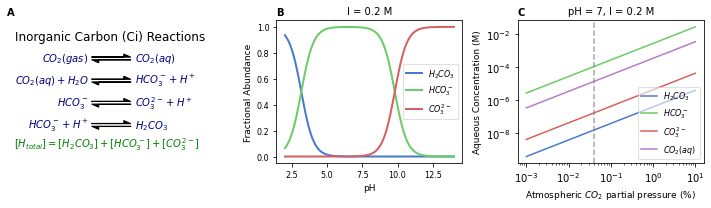

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

# Panel A: simplified scheme of inorganic carbon equilibria between gas and 
# liquid phase based on Schulz et al. Marine Chem. 2006
ax = axs[0]

plt.sca(ax)
plt.axis('off')

reactant_params = {'va': 'center', 'color': state_color, 'fontsize': 10}
title_params = {'ha': 'center', 'va': 'center', 'color': 'k', 'fontsize': 12}
eqn_params = {'ha': 'center', 'va': 'center', 'color': 'green', 'fontsize': 10}

arrow_params = {'length_includes_head': True, 'shape': 'right', 'head_starts_at_zero': True,
                "fc": arrow_color, "ec": arrow_color, "width": 0.01, "head_width": 0.1, "head_length": 0.1}

ax.text(0.65, 1, 'Inorganic Carbon (Ci) Reactions', **title_params)
# reactants
rxns = [('$CO_2(gas)$', '$CO_2(aq)$'), 
        ('$CO_2(aq) + H_2O$', '$HCO_3^- + H^+$'),
        ('$HCO_3^-$', '$CO_3^{2-} + H^+$'), 
        ('$HCO_3^- + H^+$', '$H_2CO_3$')]
ys = np.arange(0.65, -0.4, -0.35)
for ypos, (substrate, product) in zip(ys, rxns):
    ax.text(0.35, ypos, substrate, ha='right', **reactant_params)
    ax.text(1, ypos, product, ha='left', **reactant_params)
    ax.arrow(0.34, ypos+0.02, 0.55, 0, **arrow_params)
    ax.arrow(0.99, ypos-0.02, -0.55, 0, **arrow_params)
ax.text(0.6, -0.7, '$[H_{total}] = [H_2CO_3] + [HCO_3^-] + [CO_3^{2-}]$', **eqn_params)
ax.set_xlim(-0.4, 2.2)
ax.set_ylim(-1, 1.25)

# Plot the pH dependence of the mole fraction of species in H_total.
plt.sca(axs[1])
data = []
pH_range = linspace(2, 14, 100)
species = KEGG2sp['C00288']
pretty_species = [PrettyNames[k] for k in species]
for pH in pH_range:
    dG0_prime, P_dict = transform(species, pH, 0.2)
    ordered_vals = [P_dict[k] for k in species]
    data.append(ordered_vals)

fractional_abundance = matrix(data)
plt.plot(pH_range, fractional_abundance, lw=2)
plt.legend(pretty_species, loc='best', fontsize=8, framealpha=0.6)
plt.xlabel('pH', fontsize=9)
plt.ylabel('Fractional Abundance', fontsize=9)
plt.ylim((-0.05, 1.05))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('I = 0.2 M', fontsize=10)

plt.sca(axs[2])
# CO2 can have a mixing ratio of 1e-5 to 0.1
CO2_pps = np.logspace(-5, -1, 100)
CO2_concs_aq = CO2_aq(CO2_pps, 298.15)

# Plot the equilibrium concentration of dissolved inorganic carbon assuming
# that CO2 equilibrates with the atmosphere and then with H_total accoring to the pH. 
# I = 0.2 is towards the top of the biological range according to BNID 107522. 
# pH = 7, which is our media pH for the E. coli experiments.
I = 0.2
sparse = {'C00001': -1, 'C00011': -1, 'C00288': 1}  # Hydration of CO2 to H_total. 

# Calculate the keq from dGr. Use that to get the Htotal conc from CO2(aq).
keq = np.exp(-calc_dG0_prime(sparse, 7, 0.2) / (R*T))
h_total = keq * CO2_concs_aq
# Plot has CO2 partial pressure in percent on X axis
xs = CO2_pps*100

# Calculate fractional abundance of Htotal species at pH 7.0
dG0_prime, P_dict = transform(species, 7, 0.2)
for k, f in P_dict.items():
    plt.loglog(xs, f*h_total, label=PrettyNames[k])
plt.loglog(xs, CO2_concs_aq, label='$CO_2(aq)$')
plt.axvline(0.04, ls='--', color='grey', alpha=0.7)

plt.legend(fontsize=8, framealpha=0.6, loc=4)
plt.xlabel('Atmospheric $CO_2$ partial pressure (%)', fontsize=9)
plt.ylabel('Aqueous Concentration (M)', fontsize=9)
plt.title('pH = 7, I = 0.2 M', fontsize=10)

subfigure_text_args = {"fontsize": 10, "ha": "left", "va": "bottom", "fontweight": "bold"}
xpos = [-0.15, -0.0, 0]
for plabel, x, ax in zip('ABC', xpos, axs):
    ax.text(x, 1.02, plabel, transform=ax.transAxes, **subfigure_text_args)

plt.tight_layout()
plt.savefig('../figures/figS16/figS16_inorganicC_equilibria.png', facecolor='w', dpi=600)
plt.show()